In [22]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.interpolate import interp1d
import random


### Get R,G,B,W patchs information

Text(0.5, 0, 'wavelength [nm]')

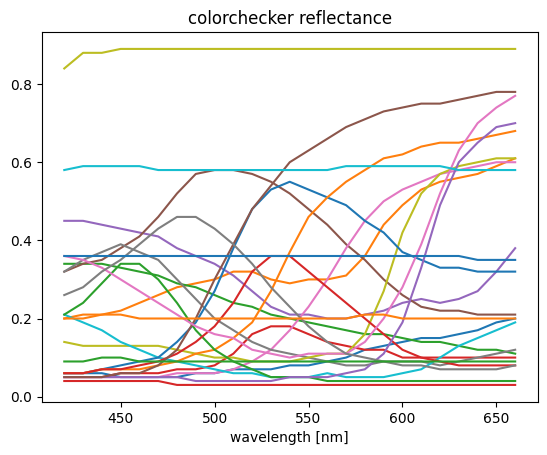

In [23]:
# Replace 'file.csv' with the path to your CSV file
file_path = '../../dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [24]:
blue = ref_CC[1:-2,12] # 87, 370
green = ref_CC[1:-2,13] # 218, 370
red = ref_CC[1:-2,14] # 349, 376
white = ref_CC[1:-2,18] # 74, 500

In [25]:
# center points for RGBW patches
center_pts = np.array([[349, 376],[218, 370], [87, 370],[74, 500]]) # R, G, B, W

# center points for all patches
all_patches_center_pts = np.array([[161, 137], [287,147], [407,151], [528, 153], [647,161], [767,164],
[150,263], [280,265], [400,260], [532, 272], [650,270], [770,280],
[145,375], [278,385], [407,387], [534,394], [657,390],  [774,397],
[141,500], [273,507], [403,514], [530, 513], [657,513], [782, 513]])

### Projector & Camera response function / Initial values

In [26]:
# bring initial value of PEF and CRF
PEF = np.load('../../dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[2:27]

CRF = np.load('./CRF.npy').T

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x21e3e8f1708>])

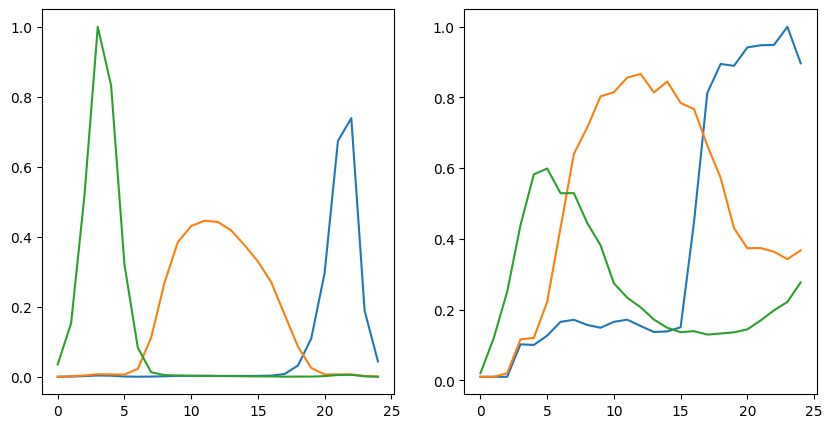

In [27]:
# Plot PEF and CRF
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.plot(PEF)
plt.subplot(122), plt.plot(CRF)

In [28]:
white_pattern = np.ones(shape = (580,890,3))

### GT Image

In [29]:
# Bring white pattern illuminated colorchecker and black pattern illuminated pattern
white_color_checker = cv2.imread('./crf_datas/20230901/white_color_checker.png', -1)[:,:,::-1] / 65535.
black_color_checker = cv2.imread('./crf_datas/20230901/black_color_checker.png', -1)[:,:,::-1] / 65535.

In [30]:
white_color_checker.max(), black_color_checker.max()

(1.0, 0.2724650949874113)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x21e3e475208>)

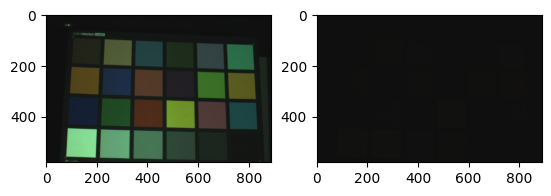

In [31]:
# image plotting
plt.subplot(121), plt.imshow(white_color_checker)
plt.subplot(122), plt.imshow(black_color_checker)

In [32]:
# Ground truth image (subtracted black image)
GT_image = np.clip(white_color_checker - black_color_checker, 0, 1)

0.9248035400930801 0.0


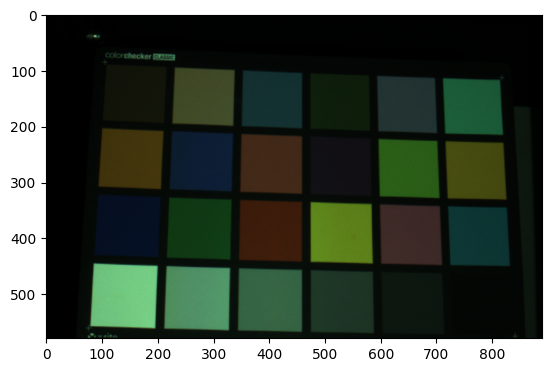

In [33]:
plt.imshow(GT_image)
print(GT_image.max(), GT_image.min())

### GT vs Rendered

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


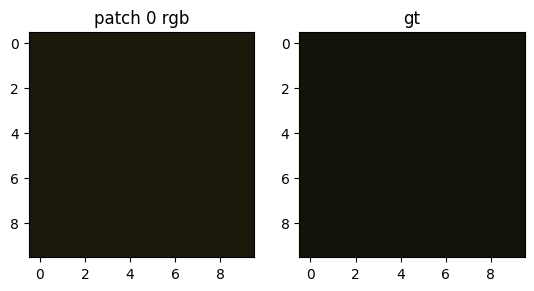

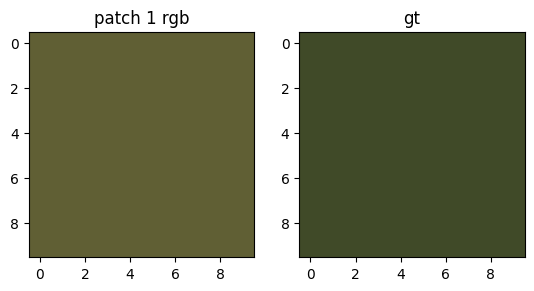

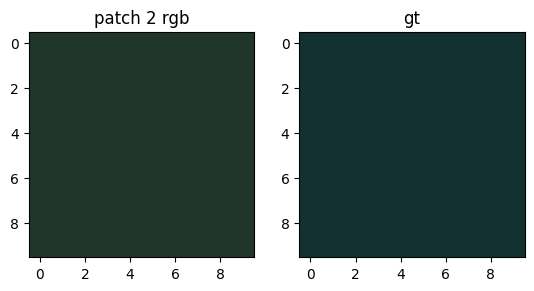

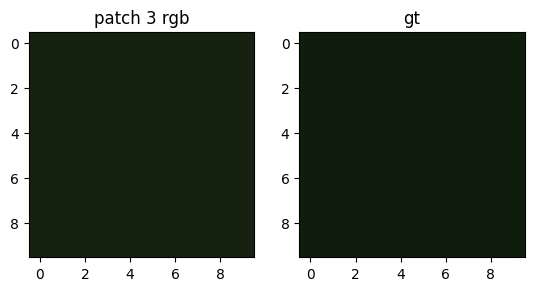

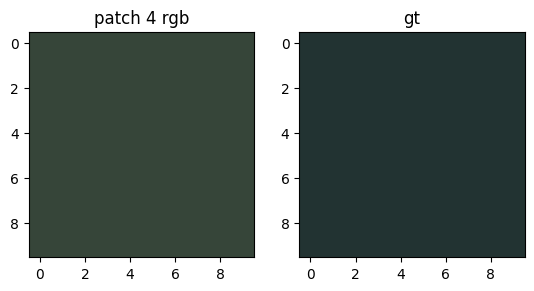

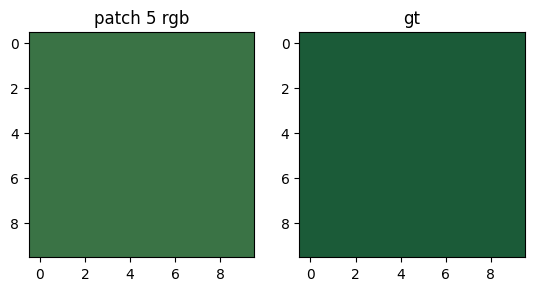

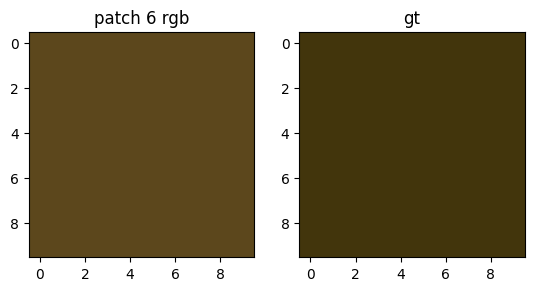

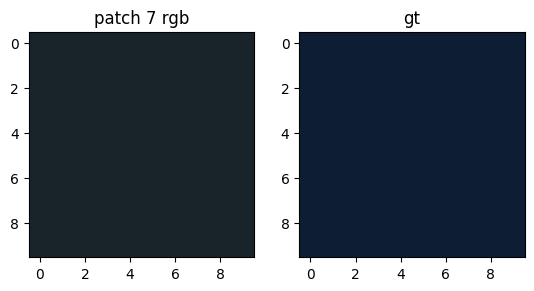

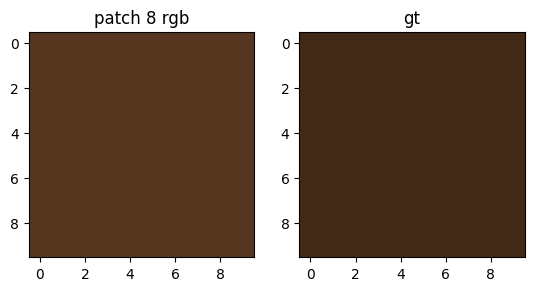

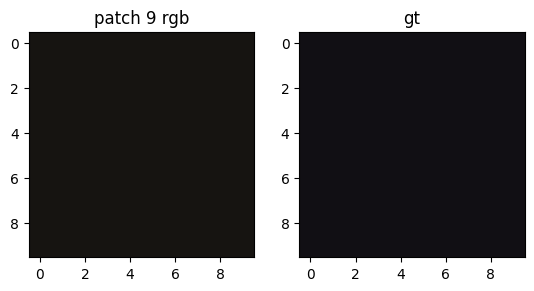

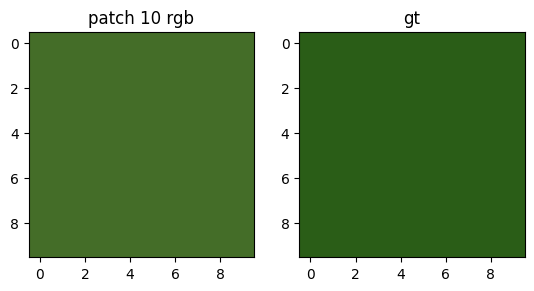

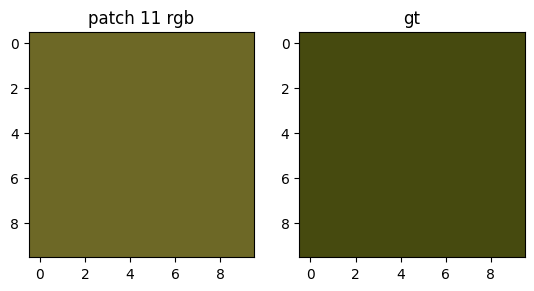

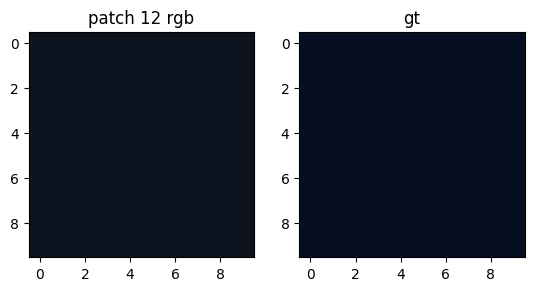

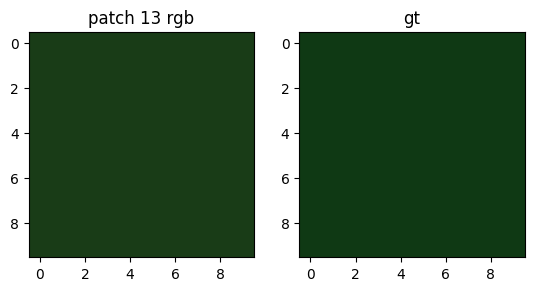

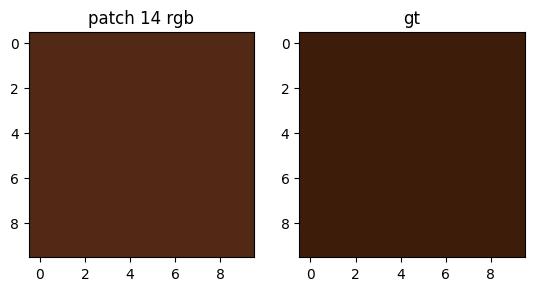

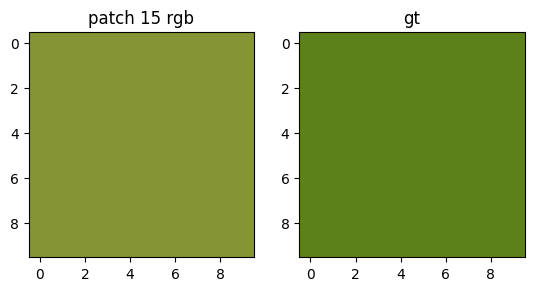

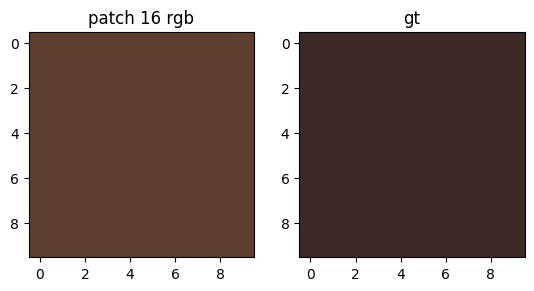

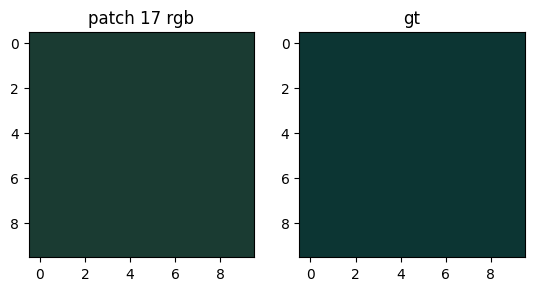

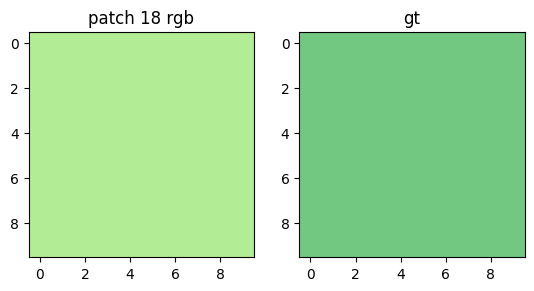

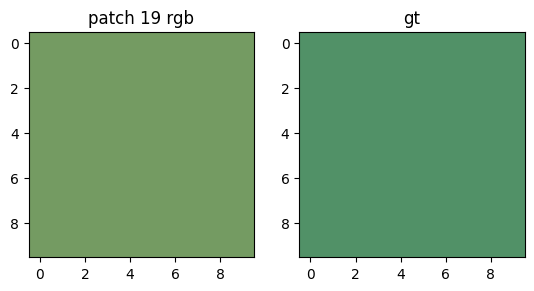

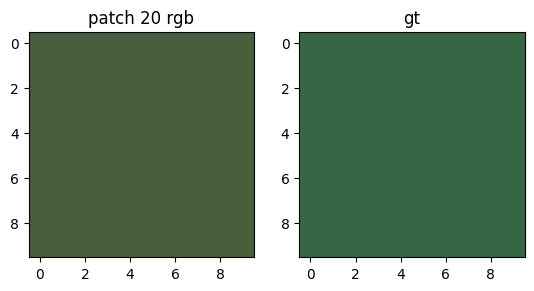

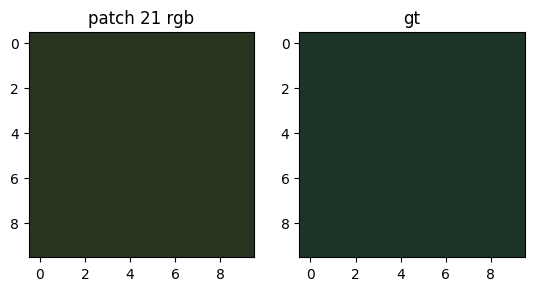

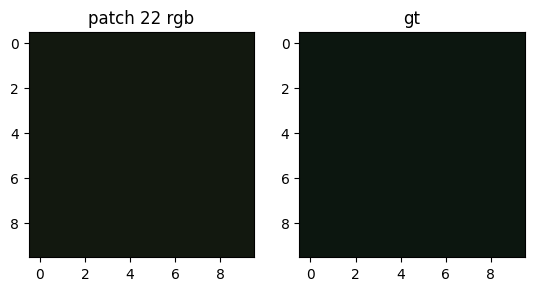

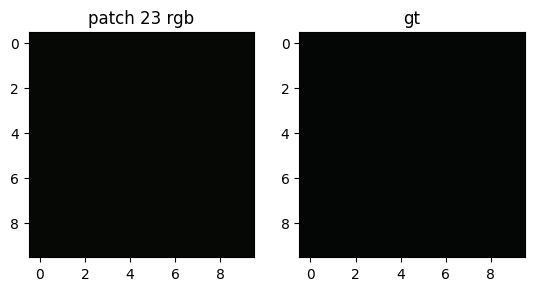

In [34]:
# patch 마다의 rgb value
white_pattern = np.ones(shape = (1, 1, 3)) * 0.5
white_pattern_hyp = white_pattern @ (PEF.T)

patch_size = 10

for patch in range(24):
    plt.figure()
    patch_rgb = np.zeros(shape = (10, 10, 3))
    patch_rgb[:,:,:] = ((white_pattern_hyp * ref_CC[1:-2, patch]) @ (CRF*0.5)).flatten()
                
    patch_gt = np.zeros(shape = (10, 10, 3))
    y_start, y_end = all_patches_center_pts[patch,1] - patch_size, all_patches_center_pts[patch,1] + patch_size 
    x_start, x_end = all_patches_center_pts[patch,0] - patch_size, all_patches_center_pts[patch,0] + patch_size
    patch_gt[:,:,:] = GT_image[y_start:y_end , x_start:x_end].reshape(-1, 3).mean(axis = 0)
    
    plt.subplot(121),plt.imshow(patch_rgb.astype(np.float32)), plt.title('patch %s rgb'%patch)
    plt.subplot(122),plt.imshow(patch_gt.astype(np.float32)), plt.title('gt')   

### Optimization preprocessing

In [35]:
# for all patches
def single_patch(patch, CRF, white_pattern_hyp):
    patch_size = 20
    
    single_patch = (white_pattern_hyp * ref_CC[1:-2, patch]) @ CRF
    gt_single_patch = GT_image[all_patches_center_pts[patch,1], all_patches_center_pts[patch,0]]
    
    y_start, y_end = all_patches_center_pts[patch,1] - patch_size, all_patches_center_pts[patch,1] + patch_size 
    x_start, x_end = all_patches_center_pts[patch,0] - patch_size, all_patches_center_pts[patch,0] + patch_size
    gt_single_patch = GT_image[y_start:y_end , x_start:x_end].reshape(-1, 3).mean(axis = 0)
    
    
    return abs(single_patch - gt_single_patch)

In [36]:
hdr_imgs = np.load('../../hdr_step5.npy').transpose(1,2,0,3)

In [37]:
dg_intensity = np.load('../../dataset/image_formation/20230825_intensity_dg.npy')

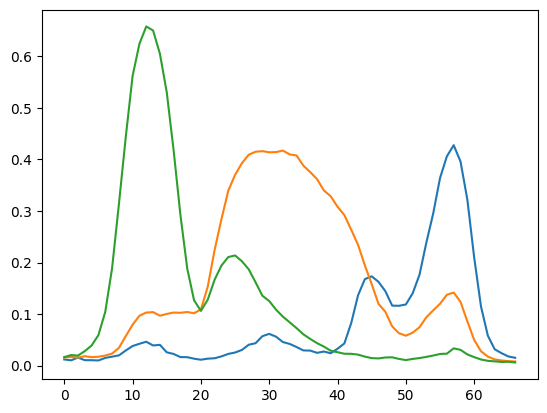

In [38]:
# args
n_illum = 318
n_patches = 24
n_channel = 3
patch_size = 3 

# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, n_channel))
patches_idx = all_patches_center_pts

# max value
max_val = hdr_imgs.max()

for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
        
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (hdr_imgs[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l] / max_val).reshape(-1, 3).mean(axis = 0)
                patches_rgb_real[l, p] = rgb_intensity

# white
patch_num = 18
start_idx, end_idx = 184, 251
patch_range = np.arange(start_idx, end_idx+1)

idx = 8

plt.plot(patches_rgb_real[start_idx:end_idx, patch_num]) # 78 ~ 102 총 25개

In [39]:
GT_white = patches_rgb_real[start_idx:end_idx, patch_num]

In [40]:
# To tensor
# blue = torch.tensor(blue.astype(np.float32))
# green = torch.tensor(green.astype(np.float32))
# red = torch.tensor(red.astype(np.float32))
# white = torch.tensor(white.astype(np.float32))

GT_white = torch.tensor(GT_white.astype(np.float32))
dg_intensity = torch.tensor(dg_intensity.astype(np.float32))

CRF = torch.tensor(CRF.astype(np.float32))
PEF = torch.tensor(PEF.astype(np.float32))

ref_CC = torch.tensor(ref_CC.astype(np.float32))
all_patches_center_pts = torch.tensor(all_patches_center_pts)

### Optimization With white line captured image

In [43]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.L1Loss()
losses = [] 
# Height, width of image
H, W = 1, 1
# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, W, 3), device = device) * 0.5

# learning rate & decay step
lr = 0.001
decay_step = 2000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(25, 7))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# to device
gt_white_hyp = ref_CC[1:-2, patch_num].to(device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

PEF = PEF.to(device)
CRF = CRF.to(device)
dg_intensity = dg_intensity.to(device)

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:-1] * CRF
    dg_intensity_opt = opt_param[:,-1] * dg_intensity
    
    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    recon_white = (gt_white_hyp * (CRF_sum * white_pattern_hyp * dg_intensity_opt))
    
    loss = loss_f(recon_white, GT_white)
    
    CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    
    weight = 0.1
    loss += weight*(CRF_dL2 + PEF_dL2)
    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / num_patch)
    optimizer.step()
    scheduler.step()
    
    # opt_param.data.clamp_(0,1)
    
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / num_patch}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param2_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses])
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_opt.detach().cpu().numpy()), plt.title('DG')
        
        plt.subplot(235), plt.plot(GT_white.detach().cpu().numpy()), plt.title('GT')
        plt.subplot(236), plt.plot(recon_white.detach().cpu().numpy()), plt.title('Recon')


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([67, 3])) that is different to the input size (torch.Size([1, 1, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (25) must match the size of tensor b (3) at non-singleton dimension 2

### Optimization with white pattern

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

Epoch : 0/10000, Loss: 0.851172597940763, LR: 0.001


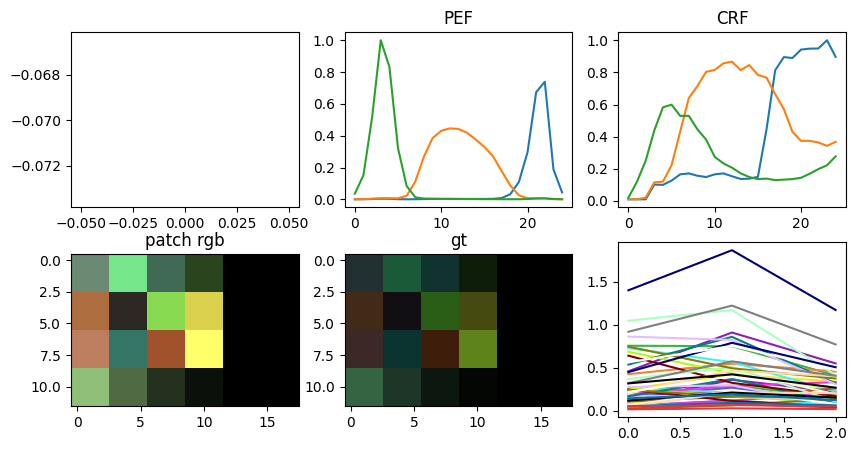

Epoch : 500/10000, Loss: 0.06220834892531826, LR: 0.001


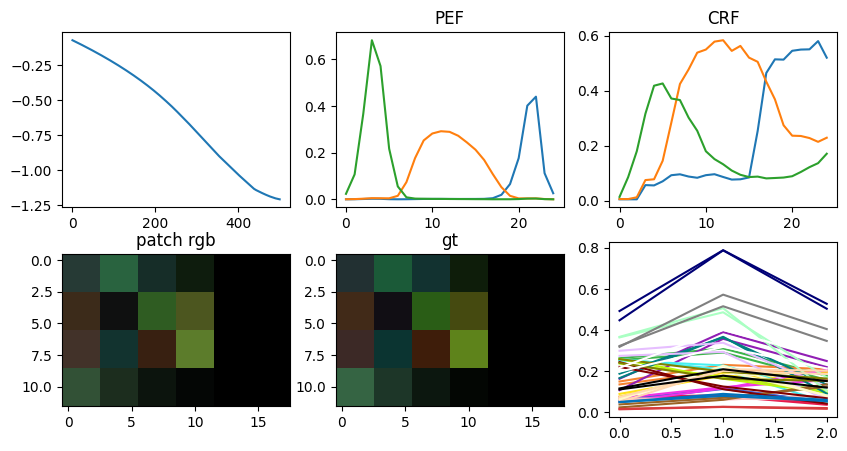

KeyboardInterrupt: 

In [55]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.L1Loss()
losses = [] 
# Height, width of image
H, W = 1, 1
# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, W, 3), device = device) * 0.5

# learning rate & decay step
lr = 0.001
decay_step = 2000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(25, 6))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# to device
GT_image = torch.tensor(GT_image, device = device)
ref_CC = ref_CC.to(device)
all_patches_center_pts = all_patches_center_pts.to(device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

PEF = PEF.to(device)
CRF = CRF.to(device)

# patch index
# rand_int = np.array([6,7,8,12,13,14,18,19,20])
rand_int = np.arange(0, 24)

# plotting line colors
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
    '#000075', '#808080', '#ffffff', '#000000', '#0072bb', '#d73b3e'
]
for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:] * CRF
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    for p in range(num_patch):
        single_loss = single_patch(p, CRF_opt, white_pattern_hyp)
        loss += single_loss.sum()
        
    loss = loss.sum()
    
    # CRF_cnst_opt, PEF_cnst_opt = opt_param[:,3:], opt_param[:,:3] 
    # CRF_dL2 = ((CRF_cnst_opt[:-1] - CRF_cnst_opt[1:])**2).sum()
    # PEF_dL2 = ((PEF_cnst_opt[:-1] - PEF_cnst_opt[1:])**2).sum()
    
    # CRF_dL2 = ((CRF_cnst_opt[:,:-1] - CRF_cnst_opt[:,1:])**2).sum()
    # PEF_dL2 = ((PEF_cnst_opt[:,:-1] - PEF_cnst_opt[:,1:])**2).sum()
    
    # CRF_dL2 = ((CRF_opt[:,:-1] - CRF_opt[:,1:])**2).sum()
    # PEF_dL2 = ((PEF_opt[:,:-1] - PEF_opt[:,1:])**2).sum()
    
    # weight = 0.1
    # loss += weight*(CRF_dL2 + PEF_dL2)
    # loss = loss.sum()
    
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / num_patch)
    optimizer.step()
    scheduler.step()
    
    # opt_param.data.clamp_(0,1)
    
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / num_patch}, LR: {optimizer.param_groups[0]['lr']}")
        # print(f" Opt param value : {opt_param}, Epoch : {i}/{epoch}, Loss: {loss.item() / 4}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses])
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')

        patch_rgb = np.zeros(shape = (12, 18, 3))
        patch_gt = np.zeros(shape = (12, 18, 3))
        
        # patch 마다의 rgb value
        for idx, patch in enumerate(rand_int): 
            # Determine the row and column starting indices for the patch
            row_start = (idx // 6) * 3
            col_start = (idx % 4) * 3
            
            # Fill the 3x3 patch with the RGB color
            patch_rgb[row_start:row_start+3, col_start:col_start+3, :] = ((white_pattern_hyp * ref_CC[1:-2, patch]) @ CRF_opt).flatten().detach().cpu().numpy()
            
            patch_gt[row_start:row_start+3, col_start:col_start+3, :] = GT_image[all_patches_center_pts[patch,1], all_patches_center_pts[patch,0]].flatten().detach().cpu().numpy()
            
            plt.subplot(234),plt.imshow(patch_rgb.astype(np.float32)), plt.title('patch rgb')
            plt.subplot(235),plt.imshow(patch_gt.astype(np.float32)), plt.title('gt')
            
            y_start, y_end = all_patches_center_pts[patch,1] - patch_size, all_patches_center_pts[patch,1] + patch_size 
            x_start, x_end = all_patches_center_pts[patch,0] - patch_size, all_patches_center_pts[patch,0] + patch_size    

            plt.subplot(236), plt.plot(((white_pattern_hyp * ref_CC[1:-2, patch]) @ CRF_opt).flatten().detach().cpu().numpy(), label = "optimized", c = colors[idx]), plt.plot(GT_image[y_start:y_end , x_start:x_end].reshape(-1, 3).mean(axis = 0).flatten().detach().cpu().numpy(), label = "gt", c = colors[idx])

        plt.show()

### Optimization with white pattern (no constant)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clip

Epoch : 0/5000, Loss: 54.159861263298986, LR: 0.001


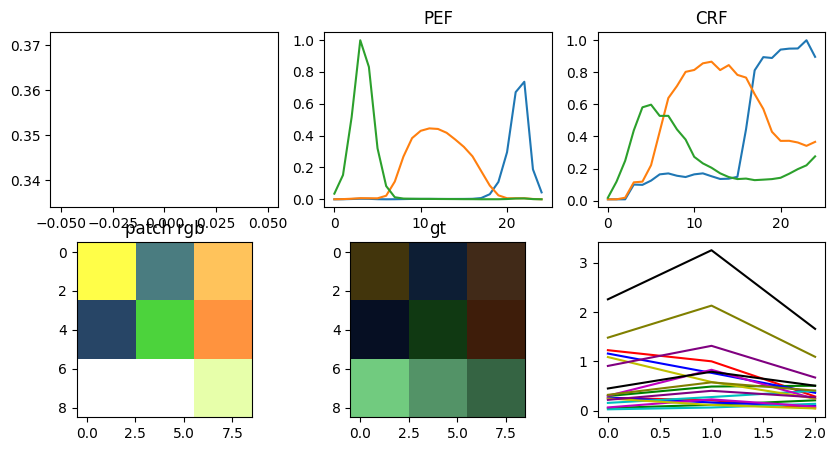

Epoch : 500/5000, Loss: 0.9795661133953437, LR: 0.001


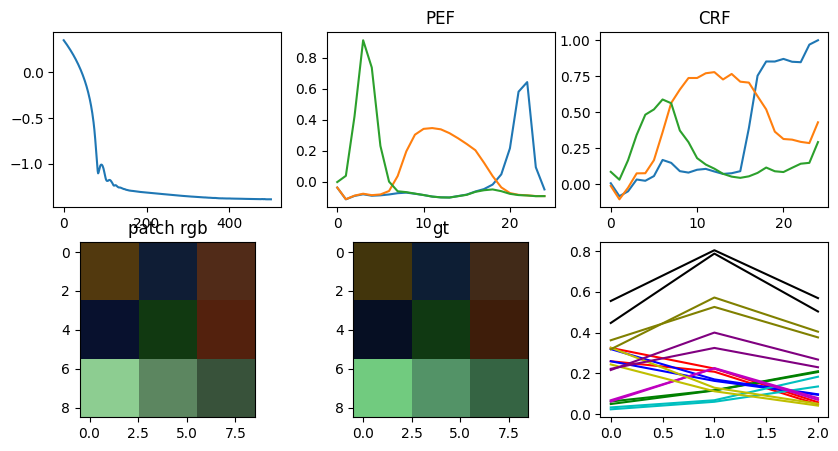

Epoch : 1000/5000, Loss: 0.9401942734149356, LR: 0.0008


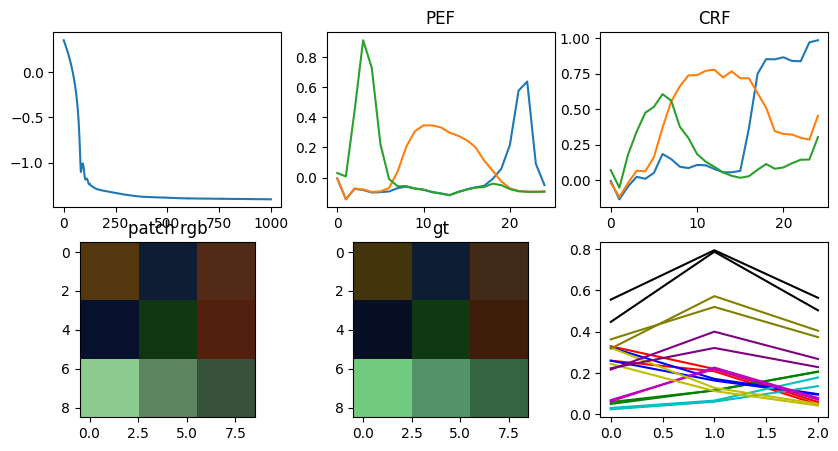

Epoch : 1500/5000, Loss: 0.908936061108429, LR: 0.0008


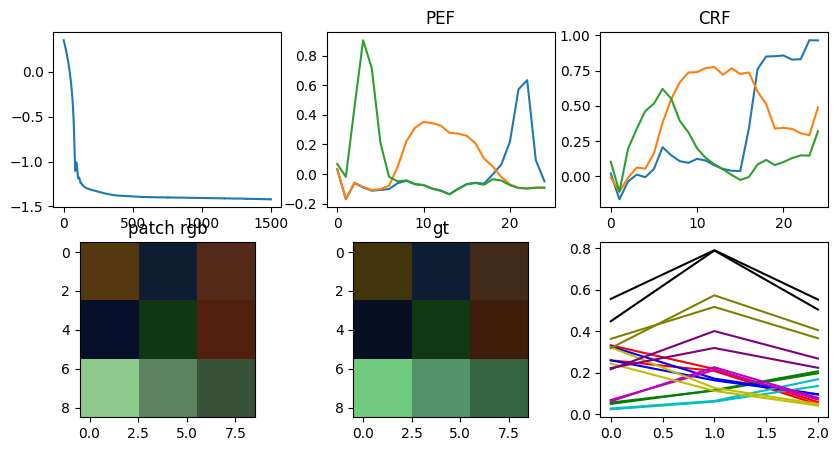

Epoch : 2000/5000, Loss: 0.8873478301705711, LR: 0.00064


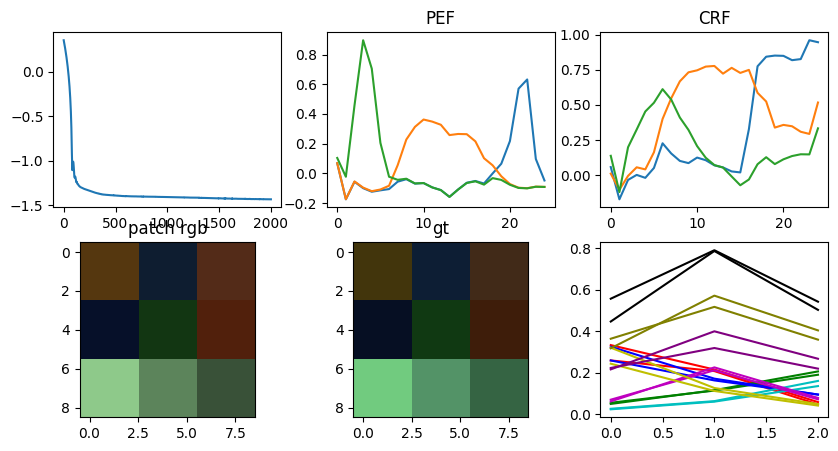

Epoch : 2500/5000, Loss: 0.8705518924817572, LR: 0.0005120000000000001


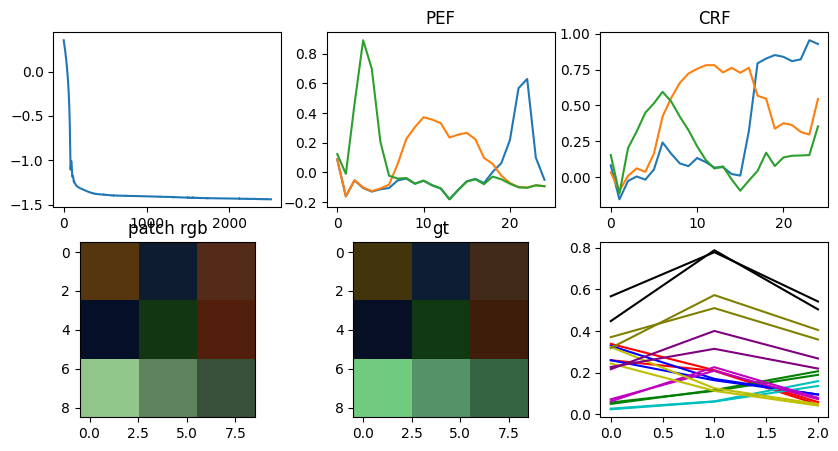

Epoch : 3000/5000, Loss: 0.8545116928513985, LR: 0.0005120000000000001


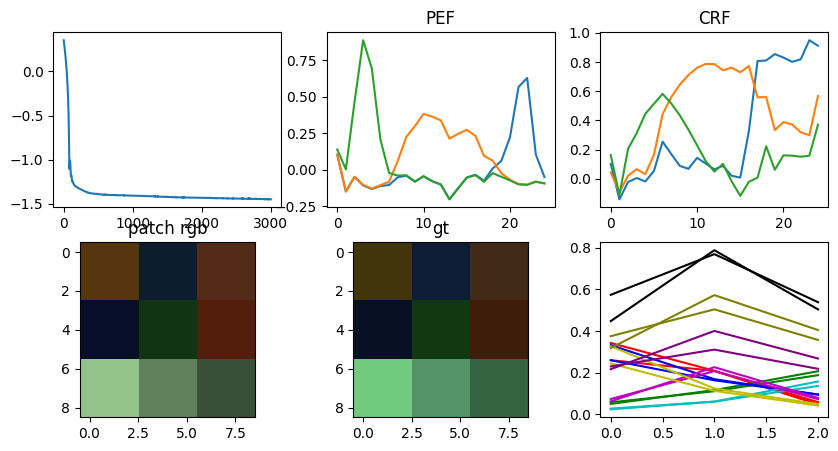

Epoch : 3500/5000, Loss: 0.8462977162951439, LR: 0.0004096000000000001


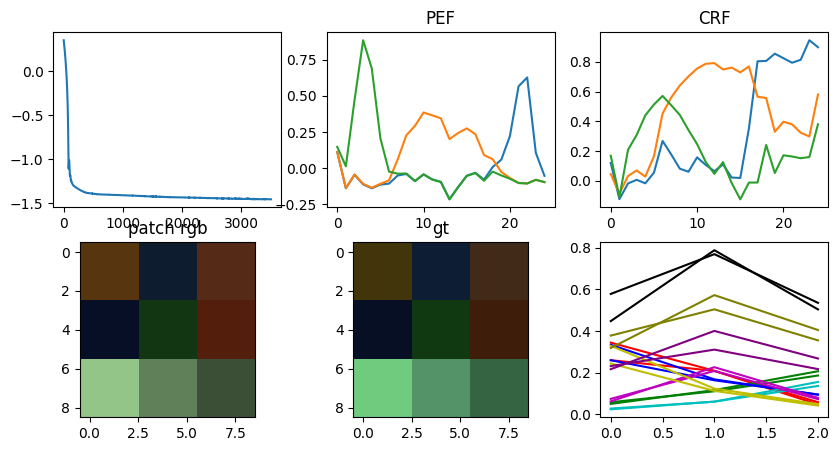

Epoch : 4000/5000, Loss: 0.8403637586848338, LR: 0.0003276800000000001


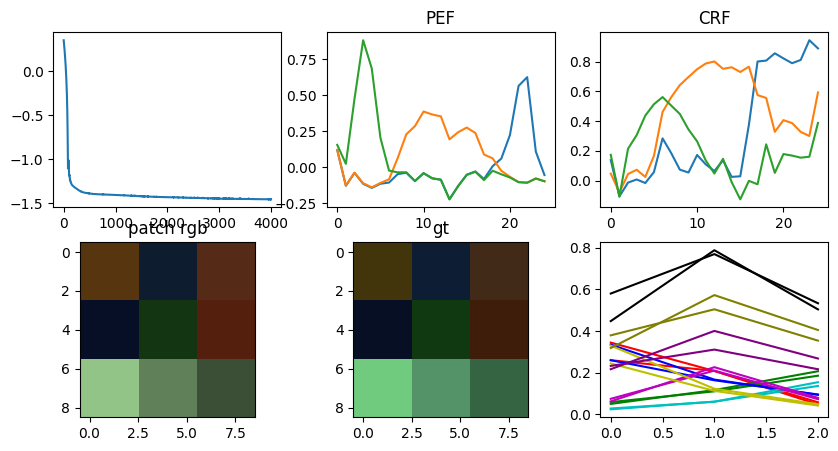

Epoch : 4500/5000, Loss: 0.8333215679253432, LR: 0.0003276800000000001


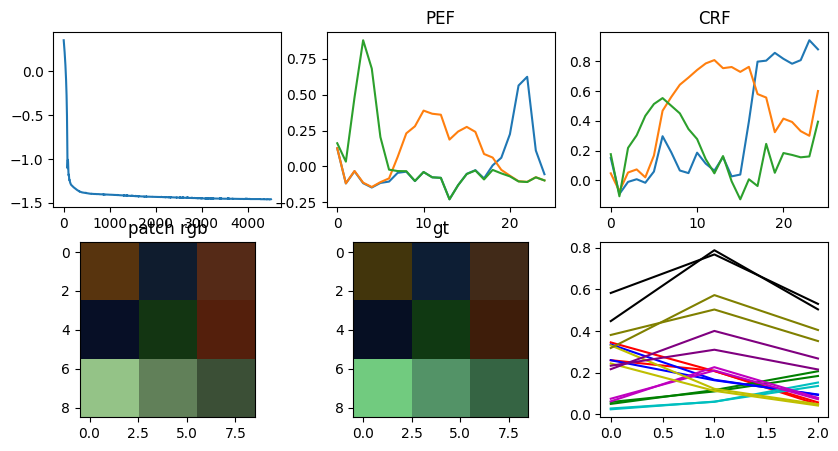

In [45]:
# arguments
device = 'cuda:0'
epoch = 5000
loss_f = torch.nn.L1Loss()
losses = [] 
# Height, width of image
H, W = 1, 1
# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, W, 3), device = device)

# learning rate & decay step
lr = 0.001
decay_step = 800
gamma = 0.8

# optimized paramter (CRF & PEF)
# initial_value = CRF
initial_value = torch.hstack((PEF, CRF))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# to device
GT_image = torch.tensor(GT_image, device = device)
ref_CC = ref_CC.to(device)
all_patches_center_pts = all_patches_center_pts.to(device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

for i in range(epoch):
    # initial loss
    loss = 0
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ opt_param[:,:3].T # opt_param[:,:3] = PEF

    for p in range(num_patch):
        single_loss = single_patch(p, opt_param[:,3:], white_pattern_hyp)
        loss += single_loss
        
    # CRF_opt, PEF_opt = opt_param[:,3:], opt_param[:,:3] 
    # # CRF_dL2 = ((CRF_opt[:,:-1] - CRF_opt[:,1:])**2).sum()
    # # PEF_dL2 = ((PEF_opt[:,:-1] - PEF_opt[:,1:])**2).sum()
    
    # CRF_dL2 = ((CRF_opt[-1] - CRF_opt[1:])**2).sum()
    # PEF_dL2 = ((PEF_opt[-1] - PEF_opt[1:])**2).sum()
    
    # weight = 0.01
    # loss += weight*(CRF_dL2 + PEF_dL2)
    loss = loss.sum()
        
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / num_patch)
    optimizer.step()
    scheduler.step()
    
    # opt_param.data.clamp_(0,1)
    
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        # print(f" Opt param value : {opt_param}, Epoch : {i}/{epoch}, Loss: {loss.item() / 4}, LR: {optimizer.param_groups[0]['lr']}")

        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses])
        # CRF & PEF
        opt_param_detach = opt_param.detach().cpu().numpy()
        plt.subplot(232), plt.plot(opt_param_detach[:,:3]), plt.title('PEF')
        plt.subplot(233), plt.plot(opt_param_detach[:,3:]), plt.title('CRF')
        
        patch_rgb = np.zeros(shape = (9, 9, 3))
        patch_gt = np.zeros(shape = (9, 9, 3))
        
        # patch 마다의 rgb value
        for idx, patch in enumerate(rand_int): 
            # Determine the row and column starting indices for the patch
            row_start = (idx // 3) * 3
            col_start = (idx % 3) * 3
            
            # Fill the 3x3 patch with the RGB color
            patch_rgb[row_start:row_start+3, col_start:col_start+3, :] = ((white_pattern_hyp * ref_CC[1:-2, patch]) @ CRF_opt).flatten().detach().cpu().numpy()
            
            patch_gt[row_start:row_start+3, col_start:col_start+3, :] = GT_image[all_patches_center_pts[patch,1], all_patches_center_pts[patch,0]].flatten().detach().cpu().numpy()
            
            plt.subplot(234),plt.imshow(patch_rgb.astype(np.float32)), plt.title('patch rgb')
            plt.subplot(235),plt.imshow(patch_gt.astype(np.float32)), plt.title('gt')
            
            y_start, y_end = all_patches_center_pts[patch,1] - patch_size, all_patches_center_pts[patch,1] + patch_size 
            x_start, x_end = all_patches_center_pts[patch,0] - patch_size, all_patches_center_pts[patch,0] + patch_size    

            plt.subplot(236), plt.plot(((white_pattern_hyp * ref_CC[1:-2, patch]) @ CRF_opt).flatten().detach().cpu().numpy(), label = "optimized", c = colors[idx]), plt.plot(GT_image[y_start:y_end , x_start:x_end].reshape(-1, 3).mean(axis = 0).flatten().detach().cpu().numpy(), label = "gt", c = colors[idx])

        plt.show()

In [ ]:
ref_CC.shape

torch.Size([28, 24])

In [ ]:
# # # Plot PEF and CRF
# plt.figure(figsize=(10, 5))
# plt.subplot(121), plt.plot(opt_param.detach().cpu().numpy())
# # plt.subplot(122), plt.plot(opt_param.detach().cpu().numpy()[:,3:])

### Scipy constraint optimization

In [ ]:
import numpy as np
from scipy.optimize import minimize, Bounds

In [ ]:
# arguments
# Height, width of image
H, W = 1, 1

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = np.ones(shape = (H, W, 3))
    
def compute_loss(initial_value):
    # initial loss
    loss = 0
    
    # Reshape the flattened initial_value
    # initial_value = initial_value.reshape(25, 6)
    initial_value = initial_value.reshape(25, 3)

    # PEF = initial_value[:,:3]
    # CRF = initial_value[:,3:]
    
    CRF = initial_value
    
    white_pattern_hyp = white_pattern @ PEF.T

    for p in range(num_patch):
        single_loss = single_patch(p, CRF, white_pattern_hyp)
        loss += single_loss

    loss = loss.sum()
    
    return loss

# Initial values
# initial_value = np.concatenate((PEF*20, CRF), axis = 1)
initial_value = CRF
# initial_value = PEF

# Specify bounds for each element
bounds = Bounds(0, 1)

# Optimize using 'L-BFGS-B' method
# method='L-BFGS-B'
result = minimize(compute_loss, initial_value.flatten(), method='L-BFGS-B',bounds=bounds)

# Reshape the result back to the original shape
optimized_initial_value = result.x.reshape(initial_value.shape)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<AxesSubplot:>, [], [], <matplotlib.legend.Legend at 0x299325abc48>)

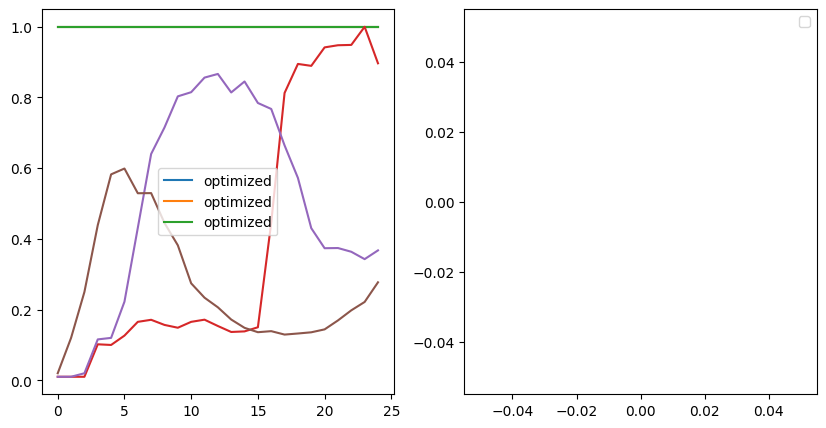

In [ ]:
# Plot PEF and CRF
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.plot(optimized_initial_value[:,:3], label = 'optimized'), plt.plot(initial_value[:,:3]), plt.legend()
plt.subplot(122), plt.plot(optimized_initial_value[:,3:], label = 'optimized'), plt.plot(initial_value[:,3:]), plt.legend()

# plt.plot(optimized_initial_value, label = 'optimized'), plt.plot(initial_value), plt.legend()